# Ex 2. Low-activity patterns
**2.1.** We now study the capacity of a Hopfield network with stochastic binary neurons and low-activity patterns. This model is proposed in the paper by [Tsodyks and Feigel’man (1988)] and discussed briefly in Chapter 17.2.6 of the book Neuronal Dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def stochastic_spike_variable(S):
    # Directly create the array `sigma` based on the condition S[i] == 1
    sigma = np.where(S == 1, 1, 0)
    return sigma

In [10]:
def generate_patterns(M, N):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    return np.random.choice([-1, 1], size=(M, N))
#initial_sequences = [np.random.choice([-1, 1], size=N) for _ in range(M)]
#seqs = np.stack(initial_sequences, axis=0)

In [18]:
def next_state_low_activity(S, seqs, a=0.5, b=0.5, c=0.02, theta=0.0, beta=4):
    """
    Args:
        S: state of the sequence
        seqs: the sequences of the patterns
        beta: constant for the tanh function
    Output:
        Updates the sequence and outputs the new sequence and the weights
        of the interactions between spins in the sequence.
    """
    W = np.zeros((len(S), len(S)))
    for i in range(len(S)):
        for j in range(len(S)):
            W[i,j] = c/len(S)*np.dot(seqs[:,i]-b,seqs[:,j]-a)
    new_S = np.tanh(beta*(W@S - theta))
    return new_S, W

In [19]:
N = 100  # Number of neurons
M = 5  # Number of patterns
patterns = generate_patterns(M, N)
# Constants for low activity patterns
a,b = 0.5, 0.5
c = (2*a*(1-a)*N)**(-1)
theta = 0.0

# flip 5% of indices
initial_state = patterns[0,:].copy()
c = 0.05
flip_indices = np.random.choice(len(initial_state), int(N*c), replace=False)
initial_state[list(flip_indices)] *= -1

print("First pattern sum:",np.sum(patterns[0,:]), patterns[0,:])
print("Intial state sum:", np.sum(initial_state), initial_state)

First pattern sum: -6 [-1 -1 -1  1 -1  1 -1  1  1 -1 -1 -1  1 -1  1  1  1  1 -1  1 -1  1 -1 -1
  1  1  1  1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1  1 -1
  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1
  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1
  1 -1  1  1]
Intial state sum: -4 [-1 -1 -1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1  1  1  1 -1  1 -1  1 -1 -1
  1  1  1  1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1
  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1
  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1
  1 -1  1  1]


In [20]:
# evolution of the network after n steps
n = 15
S = initial_state
for i in range(n):
    S, __ = next_state_low_activity(S, patterns, a, b, c, theta, beta=4)
    print("Similarity between the 1st pattern and the current state:", round(np.dot(S,patterns[0,:])/N,4))

Similarity between the 1st pattern and the current state: 0.1889
Similarity between the 1st pattern and the current state: 0.0527
Similarity between the 1st pattern and the current state: 0.0178
Similarity between the 1st pattern and the current state: 0.007
Similarity between the 1st pattern and the current state: 0.0031
Similarity between the 1st pattern and the current state: 0.0014
Similarity between the 1st pattern and the current state: 0.0007
Similarity between the 1st pattern and the current state: 0.0003
Similarity between the 1st pattern and the current state: 0.0001
Similarity between the 1st pattern and the current state: 0.0001
Similarity between the 1st pattern and the current state: 0.0
Similarity between the 1st pattern and the current state: 0.0
Similarity between the 1st pattern and the current state: 0.0
Similarity between the 1st pattern and the current state: 0.0
Similarity between the 1st pattern and the current state: 0.0


In [15]:
for m in range(M):
    print(f"Similarity between {m+1} pattern and final state: {round(np.abs(np.dot(S,patterns[m,:])/N),4)}")

Similarity between 1 pattern and final state: 0.0
Similarity between 2 pattern and final state: 0.0
Similarity between 3 pattern and final state: 0.0
Similarity between 4 pattern and final state: 0.0
Similarity between 5 pattern and final state: 0.0


### Alternative implementation

In [32]:
class StochasticHopfieldNetwork:
    def __init__(self, size, a, b, beta=4, theta=0):
        self.size = size
        self.weights = np.zeros((size, size))
        self.theta = theta  # Threshold for neuron firing
        self.a = a
        self.b = b
        self.beta = beta

    def train(self, patterns):
        self.weights = np.zeros((self.size, self.size))
        for pattern in patterns:
            self.weights += np.outer(pattern-self.a, pattern-self.b)
        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)

    def recall(self, state, steps=5):
        state = np.array(state, dtype=float)  # continuous states initialized with the pattern
        for _ in range(steps):
            firing_probability = 0.5 * (state + 1) # P{σ_i(t) = +1 | S_i(t)}
            continuous_state = np.dot(self.weights, firing_probability) - self.theta  
            state = np.tanh(continuous_state*self.beta)  # Stochastic state update
        return state

# Example usage:
size = 10
patterns = [np.random.choice([-1, 1], size, p=[0.5, 0.5]) for _ in range(3)]  # Low-activity patterns
stochastic_net = StochasticHopfieldNetwork(size, a=0.5, b=0.5, theta=0)
stochastic_net.train(patterns)
print(patterns)
recalled = stochastic_net.recall(patterns[0])
print(recalled)


[array([ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1]), array([ 1,  1, -1,  1,  1, -1, -1, -1, -1,  1]), array([-1,  1,  1,  1,  1,  1,  1, -1,  1, -1])]
[-0.9999985  -0.93020736  1.         -0.99997684 -0.99997684  1.
  1.          0.9999998   1.         -0.99418597]


### Question
Are we supposed to show with which values we get the same patterns as we do for Hopfield model or would it be enough to just state it?

a=b=0.5, c=1

**2.2.** Write methods for generating random patterns ξμ ∈ {0, 1}N with activity (i.e. average number of
(+1)’s) a, for computing the Hamming distance between new patterns ξμ and new state variables σ, and
for simulating the new model above.

In [ ]:
class StochasticHopfieldNetwork:
    def __init__(self, size, a, b, beta=4, theta=0):
        self.size = size
        self.weights = np.zeros((size, size))
        self.theta = theta  # Threshold for neuron firing
        self.a = a
        self.b = b
        self.beta = beta

    def generate_random_patterns(self, M, N):
        return np.random.choice([0, 1], size=(M, N), p=[1-a/N, a/N])
        
    def train(self, patterns):
        self.weights = np.zeros((self.size, self.size))
        for pattern in patterns:
            self.weights += np.outer(pattern-self.a, pattern-self.b)
        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)

    def recall(self, state, steps=5):
        state = np.array(state, dtype=float)  # continuous states initialized with the pattern
        for _ in range(steps):
            firing_probability = 0.5 * (state + 1) # P{σ_i(t) = +1 | S_i(t)}
            continuous_state = np.dot(self.weights, firing_probability) - self.theta  
            state = np.tanh(continuous_state*self.beta)  # Stochastic state update
        return state

    def hamming_distance(self, new_random_patterns, firing_probabilities):
        """Calculates the Hamming distance between two states."""
        return np.sum(new_random_patterns != firing_probabilities)

What does the hint mean?

**2.3.** Using the parameters a, b, θ that you found in question 2.1, compute the capacity of the network for N = 300.
Is it the same as what you found in the previous section? If not, what do you think is the origin of the discrepancy?

In [45]:
class StochasticHopfieldNetwork:
    def __init__(self, size, a, b, beta=4, theta=0):
        self.size = size
        self.weights = np.zeros((size, size))
        self.theta = theta  # Threshold for neuron firing
        self.a = a
        self.b = b
        self.beta = beta

    def generate_random_patterns(self, M):
        return np.random.choice([0, 1], size=(M, self.size), p=[1-self.a, self.a])
        
    def train(self, patterns):
        self.weights = np.zeros((self.size, self.size))
        for pattern in patterns:
            self.weights += np.outer(pattern-self.a, pattern-self.b)
        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)

    def recall(self, state, steps=5):
        state = np.array(state, dtype=float)
        for _ in range(steps):
            firing_probability = 0.5 * (state + 1)
            continuous_state = np.dot(self.weights, firing_probability) - self.theta  
            state = np.tanh(self.beta * continuous_state)
        return state

    def compute_capacity(self, max_patterns):
        for M in range(1, max_patterns + 1):
            patterns = self.generate_random_patterns(M)
            self.train(patterns)
            initial_state = patterns[0].copy()  # Testing recall for the first pattern
            recalled_state = self.recall(initial_state)
            if np.sum(recalled_state != patterns[0]) / self.size > 0.1:  # Using 10% error rate
                return M - 1  # Return the last successfully recalled number of patterns
        return M

# Parameters
N = 300
a = 0.2 # Low activity level of 10%
b = 0.1  # No offset for binary patterns
beta = 4
theta = 0

# Create the network and compute its capacity
network = StochasticHopfieldNetwork(N, a, b, beta, theta)
capacity = network.compute_capacity(100)  # Test with up to 100 patterns
print("Estimated capacity of the network:", capacity)


Estimated capacity of the network: 100


Not sure if how to compute capacity of the network

**2.4.** For a = b = 0.5, what value of the threshold θ corresponds to the best capacity? Plot the capacity as a function of θ.

In [49]:
# Parameters
N = 300
a = 0.5 # Low activity level of 10%
b = 0.5  # No offset for binary patterns
beta = 4
theta = np.linspace(0, 1, 20)
capacity = np.zeros(len(theta))

# Create the network and compute its capacity
for i,t in enumerate(theta):
    network = StochasticHopfieldNetwork(N, a, b, beta, t)
    capacity[i] = network.compute_capacity(100)  # Test with up to 100 patterns
    #print("Theta:", t, "Estimated capacity of the network:", capacity)
network = StochasticHopfieldNetwork(N, a, b, beta, theta)
#capacity = network.compute_capacity(100)  # Test with up to 100 patterns
print("Estimated capacity of the network:", capacity)

Estimated capacity of the network: [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]


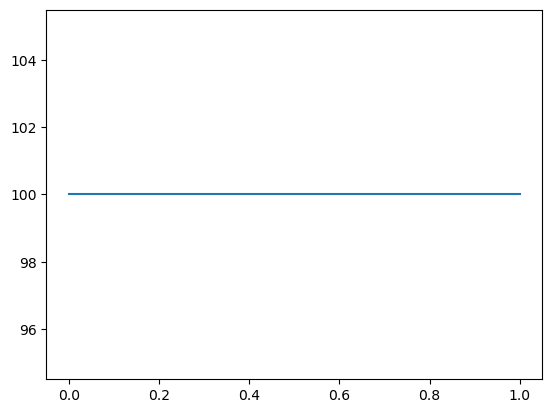

In [48]:
plt.figure()
plt.plot(theta, capacity)